# Tagging Stack-Overflow Questions

**The data**
* Python questions from Stackoverflow: [https://www.kaggle.com/stackoverflow/pythonquestions](https://www.kaggle.com/stackoverflow/pythonquestions)
* ~ 600000 questions
* each question with 0-5 tags

**The problem**

Can we predict tags from question / title texts? If so, how well?

**Approach**

Create several models and compare performances:
* Bag-of-words model
* sequential LSTM model for question bodies
* *composite LSTM model for question bodies + titles*   <== this notebook

### Configuration

In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

data_path = "../data/pythonquestions/"
ft_path = "alldata.ft"  # set this to None if you want to train your own fasttext embeddings
n_top_labels = 100  # number of top labels to reduce dataset to
max_question_words = 100
sample_size = 5000  # set to -1 to use entire dataset
normalize_embeddings = True  # whether to normalize fasttext embeddings between -1, +1
use_titles= False

tokenized_field = "q_title_tokenized" if use_titles else "q_all_body_tokenized"
content_field = "Title" if use_titles else "Body_q"

### Load data

In [26]:
from toolbox.data_prep_helpers import load_data

# slight hack: we prepared a cached reduced sample (5000 rows) of our dataset for fast cell executions
df = load_data("presentation_sample_5000/", ignore_cache=False)
# df = load_data(data_path, ignore_cache=True)

loading data from cached pickle


## Preprocessing

### Slim down number of tags

We remove all tags that are not within the top *n_top_label* tags of the dataset. Afterwards, we remove any row that has no tags left.

In [27]:
df.head()

,Id,Title,Body_q,tags
369675,29166342,Django REST API fails tests when saving models...,<p>I'm pretty lost on this. I have a ModelView...,"[python, django, rest, unit-testing]"
546234,37633165,How in pyqt change text in QPlainTextEdit() if...,<pre><code>message = QtGui.QPlainTextEdit()\ns...,"[python, pyqt, pyqt4]"
463432,33937993,Less or equal in Python is working the opposit...,<p>Less or equal when using <strong>str</stron...,[python]
477267,34574982,how to get uploaded file name in django,<p><strong>Problem Background</strong>\nI am n...,"[python, django]"
294597,24790498,error install basemap on mac,<p>I follow the setup from this link: <a href=...,"[python, matplotlib, matplotlib-basemap]"


In [28]:
from toolbox.data_prep_helpers import reduce_number_of_tags
df = reduce_number_of_tags(df, n_top_labels)

deleting element python from top_tags


/home/lukas/Master/SeminarNLP/project/so_nlp/toolbox/data_prep_helpers.py:88: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  dataframe["tags"] = dataframe["tags"].apply(lambda x: [tag for tag in x if tag in top_tags])


### Remove HTML Formatting

In [29]:
df["Body_q"].iloc[2000]

'<p>I am trying to find a way for accessing mysqlserver which is installed in xampp (in ubunutu) for a web application and a python program simultanesously. Actually I have a web application and a python program (both need mysql server to run), which has to be run simultaneously. While trying to run both at same time it showing different errors.</p>\n'

In [30]:
from toolbox.data_prep_helpers import remove_html_tags

# question bodies are stored as html code, we need to extract the content only
remove_html_tags(df, ["Body_q"])
pass  # suppress outpu

In [31]:
df["Body_q"].iloc[2000]

'I am trying to find a way for accessing mysqlserver which is installed in xampp (in ubunutu) for a web application and a python program simultanesously. Actually I have a web application and a python program (both need mysql server to run), which has to be run simultaneously. While trying to run both at same time it showing different errors.\n'

### Tokenization
We need to tokenize questions in order to be able to apply/train embeddings on them.

To do this, we use the word_tokenize function from the nltk library ([https://www.nltk.org/api/nltk.tokenize.html](https://www.nltk.org/api/nltk.tokenize.html)) to transform multiple sentences of a question to a 1-dimensional list of tokens. 

In [33]:
from toolbox.data_prep_helpers import generate_question_level_tokens

# tokenization example
generate_question_level_tokens("Please help! How do I format in markdown?")

['please', 'help', '!', 'how', 'do', 'i', 'format', 'in', 'markdown', '?']

In [34]:
df["q_body_tokenized"] = df["Body_q"].apply(generate_question_level_tokens)
df["q_title_tokenized"] = df["Title"].apply(generate_question_level_tokens)

### Remove samples with too many tokens

In [37]:
# remove questions that contain more than max_questions_words words to meet memory limitations. 
df = df[df["q_body_tokenized"].apply(len).between(1, max_question_words)]

In [38]:
df.shape

(817, 6)

### FastText word embeddings

We trained our own embeddings, because Code is often related to certain key words."Pandas" for instance is related to the python library. Hence it's meaning within python code is totally different from it's meaning in pretrained embeddings.


Why FastText?

FastText includes reasonable mechanisms to deal with words, where no embedding exists. 
It represents a word as a bag of character n-grams. For words, which are out of vocab it calculates the embedding by combining the specific n-grams. For Training we used skip gram and cbow, where sg turned out to have a better perfomance.


In [8]:
from toolbox.data_prep_helpers import load_fasttext_embeddings, create_FastText_embeddings

# Use FastText to include solution for out-of-vocab words
if ft_path is not None:
    print("loading fastText embeddings")
    wv = load_fasttext_embeddings(ft_path)
else:
    print("creating fastText embeddings")
    wv = create_FastText_embeddings(train_data, content_field)
wv.init_sims()

loading fastText embeddings


### Apply embeddings

In [45]:
import numpy as np

X_t = df["q_title_tokenized"].apply(lambda x: np.array([wv.word_vec(w, use_norm=normalize_embeddings) for w in x]))
X_b = df["q_body_tokenized"].apply(lambda x: np.array([wv.word_vec(w, use_norm=normalize_embeddings) for w in x]))

### Transform data to model-compatible format

Pad question embeddings to equal length to unify tensor shapes

In [53]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padding_element = np.array([0.0] * X_t.iloc[0].shape[-1])

X_t = pad_sequences(X_t, padding="post", dtype='float32', value=padding_element)
X_b = pad_sequences(X_b, padding="post", dtype='float32', value=padding_element)
print(X_t.shape)
print(X_b.shape)

(817, 28, 100)
(817, 100, 100)


#### Target data
With the MultiLabelBinarizer we create a (sample x label) matrix where for each record a 1 represents the presence of a certain label and a 0 its absence. (Similar to one-hot-encoding for single class problems) 

In [54]:
from sklearn.preprocessing import MultiLabelBinarizer

label_encoder = MultiLabelBinarizer()
label_encoder.fit(df["tags"])
y = label_encoder.transform(df["tags"])

## Training

Our title/body model takes title and body token sequences as separate inputs. These inputs are each passed through a masking layer which allows following layers (i.e. the lstm layers) to skip padding elements in the sequence. The masked inputs are processed by two separate lstm layers, whos last output vectors are concatenated to form one big context vector. This context is then passed through a fully connected layer with a sigmoid activation function, which assigns "independent" probabilities to each output class.

The model is visualized in the diagram below. For this visual example, we go with the following properties:
* batch size: 32
* sequence length: 50
* embedding size: 100
* lstm size (each): 64

![model architecture](graphics/title_body_model.svg)

### Conduct GridSearch to find "optimal" hyperparameters

In [56]:
from toolbox.training import grid_search_es
from models.title_body_lstm import create_model

search_params = {
    "lstm_layer_size": [256, 128],
    "lstm_dropout": [0.0, 0.2],
    "num_mid_dense": [1],
    
    # don't change these:
    "output_dim": [y.shape[-1]]
}

all_hists = grid_search_es([X_b, X_t], y, create_model, search_params, max_epochs=10)

best_params, best_hist, best_loss = min(all_hists, key=lambda x: x[2])

epoch_lengths = [len(h["val_loss"]) for h in best_hist]
print(f"best combindation: {best_params}")
print(f"avg min val_loss: {best_loss} -- epoch counts: {epoch_lengths}")

{'lstm_layer_size': 256, 'lstm_dropout': 0.0, 'num_mid_dense': 1, 'output_dim': 100}
average min val_loss: 0.22171485442213895 -- epochs: [10, 10] -- time: 79.77 seconds
{'lstm_layer_size': 256, 'lstm_dropout': 0.2, 'num_mid_dense': 1, 'output_dim': 100}
average min val_loss: 0.24324332886352773 -- epochs: [10, 10] -- time: 374.84 seconds
{'lstm_layer_size': 128, 'lstm_dropout': 0.0, 'num_mid_dense': 1, 'output_dim': 100}
average min val_loss: 0.3992069592563118 -- epochs: [10, 10] -- time: 37.16 seconds
{'lstm_layer_size': 128, 'lstm_dropout': 0.2, 'num_mid_dense': 1, 'output_dim': 100}
average min val_loss: 0.4212497214718563 -- epochs: [10, 10] -- time: 29.08 seconds
best combindation: {'lstm_layer_size': 256, 'lstm_dropout': 0.0, 'num_mid_dense': 1, 'output_dim': 100}
avg min val_loss: 0.22171485442213895 -- epoch counts: [10, 10]


### Create train and test dataset split

In [58]:
from sklearn.model_selection import train_test_split

# Train and test split with two datasets. Requires the zip to make the split for the question body and the question title
X_train_z, X_test_z, y_train, y_test = train_test_split(list(zip(X_b, X_t)), y, test_size=0.2)
X_train = list(zip(*X_train_z))
X_test = list(zip(*X_test_z))

#Convert to numpy arrays 
X_train=[np.array(X_train[0]), np.array(X_train[1])]
X_test=[np.array(X_test[0]), np.array(X_test[1])]

### Create the model

In [59]:
model = create_model(**best_params)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, None, 100)]  0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, None, 100)]  0                                            
__________________________________________________________________________________________________
masking_16 (Masking)            (None, None, 100)    0           input_17[0][0]                   
__________________________________________________________________________________________________
masking_17 (Masking)            (None, None, 100)    0           input_18[0][0]                   
____________________________________________________________________________________________

### Train it

In [61]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
import datetime

model_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir="logs/fit/" + model_name

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, verbose=0, restore_best_weights=True),
    TensorBoard(log_dir=log_dir, histogram_freq=1)
]

model.fit(x=X_train, y=y_train, batch_size=128, epochs=5, validation_data=[X_test, y_test], callbacks=callbacks)

Train on 653 samples, validate on 164 samples
Epoch 1/5
653/653 [==============================] - 3s 5ms/sample - loss: 0.3682 - accuracy: 0.8467 - val_loss: 0.1896 - val_accuracy: 0.9366
Epoch 2/5
653/653 [==============================] - 3s 5ms/sample - loss: 0.1395 - accuracy: 0.9679 - val_loss: 0.0913 - val_accuracy: 0.9849
Epoch 3/5
653/653 [==============================] - 3s 5ms/sample - loss: 0.0867 - accuracy: 0.9863 - val_loss: 0.0828 - val_accuracy: 0.9849
Epoch 4/5
653/653 [==============================] - 3s 5ms/sample - loss: 0.0806 - accuracy: 0.9863 - val_loss: 0.0780 - val_accuracy: 0.9849
Epoch 5/5
653/653 [==============================] - 3s 5ms/sample - loss: 0.0735 - accuracy: 0.9863 - val_loss: 0.0760 - val_accuracy: 0.9849


## Model Evaluation

### F1_Micro Score Optimization

F1_Score = 2 * (precision * recall) / (precision + recall)

For Multi-Labeling we used the F1_Micro score which calculates the number of "True Positives", "False Positives" and "False Negatives" globally.
As we use the sigmoid function within our model we get values between 0 and 1 for every label. Hence it is necessary to define a threshold to decide whether a certain label is predicted (=1). The threshold, that maximizes the f1_micro score is calculated within the output_evaluation function. 

Model Evaluation

normalize_embeddings = True, learning_rate = None, vocab_size = None, epochs=5
Parameter Settings:
 Sample size = 5000, Max. number of words per question = 100, Number of Top Labels used = 100

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, None, 100)]  0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, None, 100)]  0                                            
__________________________________________________________________________________________________
masking_16 (Masking)            (None, None, 100)    0           input_17[0][0]                   
______________________________________________________________________________

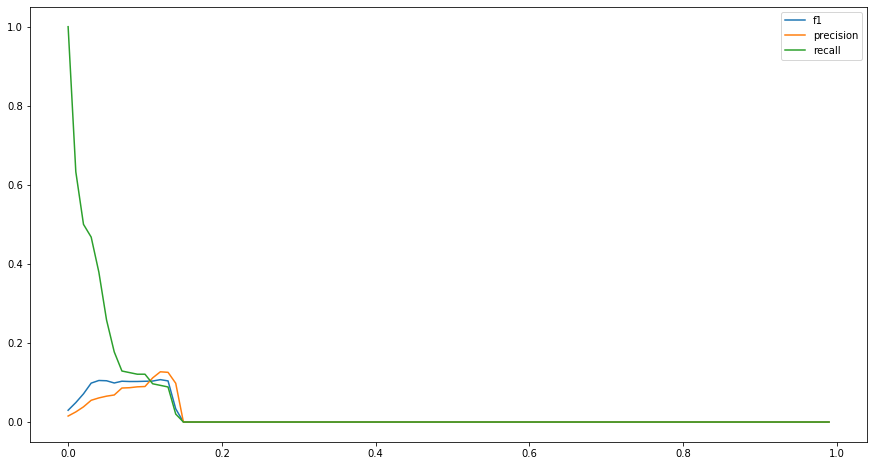


Metrics with optimized threshold of 0.12
 Macro Evaluation: f1_Score= 0.0031655913978494623 , Recall = 0.01125 , Precision = 0.0019296987087517937
 Micro Evaluation: f1_Score= 0.10722610722610722 , Recall = 0.09274193548387097 , Precision = 0.1270718232044199


In [67]:
from toolbox.evaluation import output_evaluation

predictions = model.predict(X_test)
opt_thres = output_evaluation(model, sample_size, max_question_words, n_top_labels, y_test, predictions, normalize_embeddings, None, None, 5)

### Looking at some examples

For this, we use a prepared model trained on 80% of the full data corpus (after cutting)

In [10]:
import pickle
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from toolbox.data_prep_helpers import load_fasttext_embeddings


path_to_model = "qtb_full_sg.h5"
model = keras.models.load_model(path_to_model)

with open("validation_questions.pkl", "rb") as in_file:
    validation_questions = pickle.load(in_file)
    
with open("label_encoder.pkl", "rb") as in_file:
    label_encoder = pickle.load(in_file)
    

# Use FastText to include solution for out-of-vocab words
wv = load_fasttext_embeddings("sg_model.ft")
wv.init_sims()

In [15]:
X_val_t = validation_questions["q_title_tokenized"].apply(lambda x: np.array([wv.word_vec(w, use_norm=normalize_embeddings) for w in x]))
X_val_b = validation_questions["q_all_body_tokenized"].apply(lambda x: np.array([wv.word_vec(w, use_norm=normalize_embeddings) for w in x]))

padding_element = np.array([0.0] * X_val_t.iloc[0].shape[-1])
X_val_t = pad_sequences(X_val_t, padding="post", dtype='float32', value=padding_element, maxlen=X_val_t.iloc[0].shape[1])
X_val_b = pad_sequences(X_val_b, padding="post", dtype='float32', value=padding_element)

print(X_val_t.shape)
print(X_val_b.shape)

y_val = label_encoder.transform(validation_questions["tags"])
print(y_val.shape)

(100, 100, 100)
(100, 100, 100)
(100, 100)


In [21]:
from toolbox.evaluation import binarize_model_output 

predictions = model.predict([X_val_b, X_val_t])

l_pred = label_encoder.inverse_transform(binarize_model_output(predictions, threshold=0.38))
l_true = label_encoder.inverse_transform(y_val)
raw_texts = validation_questions[content_field]
titles = validation_questions["Title"]

for pred, act, raw_txt, title in zip(l_pred, l_true, raw_texts, titles):
    print(f"TRUE: {act}\nPRED: {pred}\n")
    print(f"{title}")
    print("----------------------------")
    print(raw_txt)
    print(f"###########################\n")


TRUE: ('machine-learning', 'scikit-learn')
PRED: ('scikit-learn',)

How to obtain information gain using scikit-learn?
----------------------------
I see that DecisionTreeClassifier accepts criterion='entropy', which means that it must be using information gain as a criterion for splitting the decision tree. 
What I need is the information gain for each feature at the root level, when it is about to split the root node.

###########################

TRUE: ('parsing',)
PRED: ('nltk',)

Python ast and tokenizer
----------------------------
In python how would you use the tokenize module in conjunction with the ast module? Both use different node types how would you correlate the two together? Is there a way? Possibly the parser module?

###########################

TRUE: ('class',)
PRED: ('class', 'oop')

Python class inheritance
----------------------------
I have this code:
class A(object):
    def __init__(self):
       print " A"

class B(A):
    def __init__(self):
        print "B"

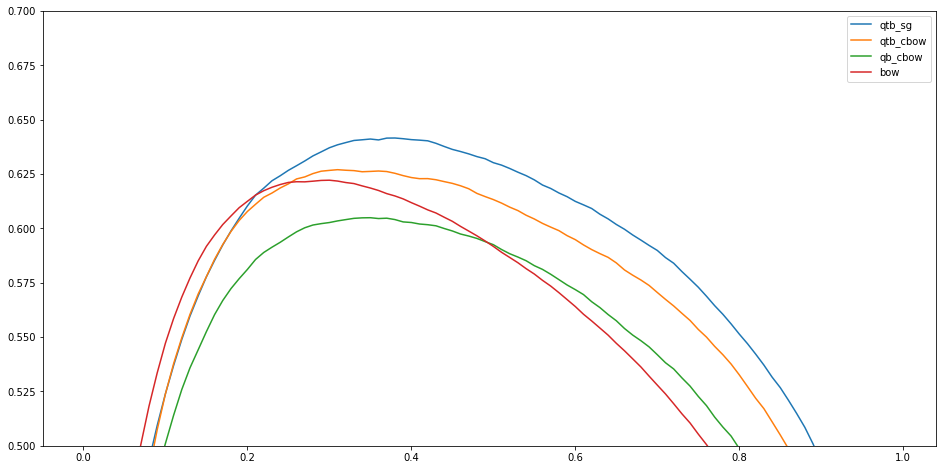

In [15]:
from toolbox.evaluation import compare_f1_plots

f1_files = [
    "qtb_full_sg_f1.pkl", 
    "qtb_full_cbow_f1.pkl",
    "qb_full_cbow_f1.pkl", 
    "bow_full_f1.pkl"
]

f1_files = [f"model_bins/{f}" for f in f1_files]

compare_f1_plots(f1_files, ["qtb_sg", "qtb_cbow", "qb_cbow", "bow"])